<a href="https://colab.research.google.com/github/w1llyVR/Data-Science-Intro/blob/main/Mineral_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install pyjanitor matplotlib==3.5.1 missingno numpy pandas pyreadr seaborn session-info upsetplot==0.6.
!pip install --upgrade ipython

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
datos_mineria_url = 'https://nrvis.com/data/mldata/pima-indians-diabetes.csv'

!wget -O ./data/datos_mineria.csv { datos_mineria_url } -q

# Nombrar los Encabezados

In [ ]:
import janitor
import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import pyreadr
import seaborn as sns
import session_info
import upsetplot


In [ ]:
mineria_data = pd.read_csv(
    filepath_or_buffer="./data/datos_mineria.csv",
    sep=",",
    names=[
        "Cantidad_de_mineral_extraído",
        "Tamaño del yacimiento",
        "Número de trabajadores",
        "Producción diaria",
        "Profundidad de la mina",
        "Recuperación de mineral",
        "Consumo de energía",
        "Dureza del mineral",
        "Porcentaje de recuperación de mineral"
    ]
)

In [35]:
mineria_data.info()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Cantidad_de_mineral_extraído           768 non-null    int64  
 1   Tamaño del yacimiento                  768 non-null    int64  
 2   Número de trabajadores                 768 non-null    int64  
 3   Producción diaria                      768 non-null    int64  
 4   Profundidad de la mina                 768 non-null    int64  
 5   Recuperación de mineral                768 non-null    float64
 6   Consumo de energía                     768 non-null    float64
 7   Dureza del mineral                     768 non-null    int64  
 8   Porcentaje de recuperación de mineral  768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [36]:
mineria_data.isna()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Cantidad_de_mineral_extraído,Tamaño del yacimiento,Número de trabajadores,Producción diaria,Profundidad de la mina,Recuperación de mineral,Consumo de energía,Dureza del mineral,Porcentaje de recuperación de mineral
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
763,False,False,False,False,False,False,False,False,False
764,False,False,False,False,False,False,False,False,False
765,False,False,False,False,False,False,False,False,False
766,False,False,False,False,False,False,False,False,False


# Extender las funcionalidades de PANDAS

In [37]:
@pd.api.extensions.register_dataframe_accessor("missing")
class Mi_Clase:
  def __init__(self, pandas_obj):
    self._obj = pandas_obj

  def numero_faltantes(self):
    return self._obj.isna().sum().sum()

  def numero_completados(self):
    return self._obj.size - self._obj.missing.numero_faltantes()

  def missing_variable_summary(self) -> pd.DataFrame:
    return self._obj.isnull().pipe(
            lambda df_1: (
                df_1.sum()
                .reset_index(name="n_missing")
                .rename(columns={"index": "variable"})
                .assign(
                    n_cases=len(df_1),
                    pct_missing=lambda df_2: df_2.n_missing / df_2.n_cases * 100,
                )
            )
        )

  def missing_case_summary(self) -> pd.DataFrame:
        return self._obj.assign(
            case=lambda df: df.index,
            n_missing=lambda df: df.apply(
                axis="columns", func=lambda row: row.isna().sum()
            ),
            pct_missing=lambda df: df["n_missing"] / df.shape[1] * 100,
        )[["case", "n_missing", "pct_missing"]]
    
  def missing_variable_plot(self):
    df = self._obj.missing.missing_variable_summary().sort_values("n_missing")

    plot_range = range(1, len(df.index) + 1)

    plt.hlines(y=plot_range, xmin=0, xmax=df.n_missing, color="black")

    plt.plot(df.n_missing, plot_range, "o", color="black")

    plt.yticks(plot_range, df.variable)

    plt.grid(axis="y")

    plt.xlabel("Number missing")
    plt.ylabel("Variable")

  def proportion_missing(self):
    pass
  

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-37-c47e94921ac4>:2: UserWarning: registration of accessor <class '__main__.Mi_Clase'> under name 'missing' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  class Mi_Clase:


In [38]:
#Número de Espacios Completados
mineria_data.missing.missing_case_summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,case,n_missing,pct_missing
0,0,0,0.0
1,1,0,0.0
2,2,0,0.0
3,3,0,0.0
4,4,0,0.0
...,...,...,...
763,763,0,0.0
764,764,0,0.0
765,765,0,0.0
766,766,0,0.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


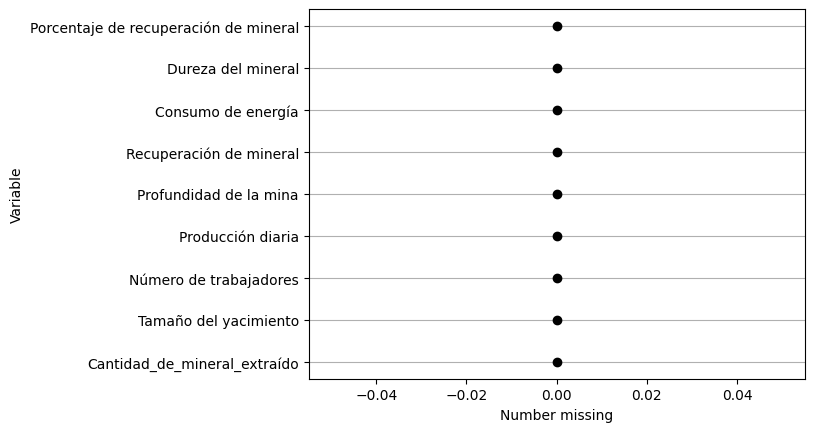

In [39]:
mineria_data.missing.missing_variable_plot()